In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import dynamo
import dynamo as dyn
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
dyn_adata = dyn.sample_data.zebrafish()
print("original data shape:", dyn_adata.shape)


|-----> Downloading data to ./data/zebrafish.h5ad


original data shape: (4181, 16940)


## Convert and Output Data for R Seurat inputs

In [2]:
import scipy
import scipy.io
dyn.preprocessing.convert_layers2csr(dyn_adata)
dyn.preprocessing.unique_var_obs_adata(dyn_adata)
dyn.preprocessing.filter_cells_by_outliers(dyn_adata)
# scipy.io.mmwrite("counts.mtx", dyn_adata.X)
# scipy.io.mmwrite("spliced.mtx", dyn_adata.layers["spliced"])
# scipy.io.mmwrite("unspliced.mtx", dyn_adata.layers["unspliced"])


|-----------> filtering cells by layer:X
|-----------> filtering cells by layer:spliced
|-----------> filtering cells by layer:unspliced
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> inplace subsetting adata by filtered cells


AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter'
    layers: 'spliced', 'unspliced'

In [3]:
print(dyn_adata)

AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter'
    layers: 'spliced', 'unspliced'


In [4]:
pd.Series(dyn_adata.obs_names).to_csv("./data/cell_names.csv")
pd.Series(dyn_adata.var_names).to_csv("./data/var_names.csv")


In [5]:
seurat_X_pca = pd.read_csv("./R-seurat-test/X_pca.csv")
seurat_features = pd.read_csv("./R-seurat-test/features_attributes.csv")
seurat_residual_variance = seurat_features["residual_variance"]
seurat_residual_mean = seurat_features["residual_mean"]




In [6]:
print(seurat_features.shape)
seurat_features[:2]

(14561, 13)


,Unnamed: 0,detection_rate,gmean,variance,residual_mean,residual_variance,theta,(Intercept),log_umi,genes_log_gmean_step1,step1_theta,step1_(Intercept),step1_log_umi
0,tmsb4x,0.996880,24.044729,646.209685,1.319695,6.650225,7.996670,-5.383010,2.487423,True,3.043973,-0.987639,1.299996
1,rpl8,0.970722,9.071542,268.856675,0.324635,1.309959,8.595067,-7.094549,2.763408,True,9.728702,-7.069017,2.803896


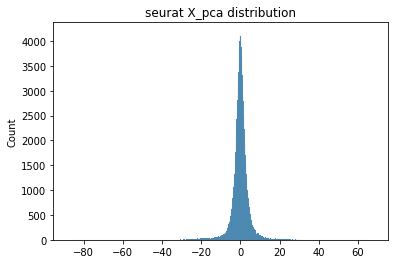

In [7]:
X_pca_arr = seurat_X_pca.to_numpy().flatten()
sns.histplot(X_pca_arr).set_title("seurat X_pca distribution")
plt.show()
# sns.histplot(seurat_residual_mean.to_numpy().flatten()).set_title("seurat residual mean")
# plt.show()
# sns.histplot(seurat_residual_variance.to_numpy().flatten()).set_title("seurat residual variance")
# plt.show()

In [8]:
print(seurat_X_pca.shape)
print(dyn_adata.shape)


(4167, 50)
(4167, 16940)


In [9]:
dyn_adata.obs_names[:10]


Index(['CAGAGAGAGGCGATAC-1-0', 'AACTGGTAGTGGAGAA-1-0', 'TTGGCAAAGGGCTTCC-1-0',
       'CATATGGAGGACATTA-1-0', 'TTCTTAGGTACGACCC-1-0', 'AGACGTTAGGGTTTCT-1-0',
       'CACAGTAAGGGTTTCT-1-0', 'AGCTCCTTCTACGAGT-1-0', 'GACGTGCCACTCAGGC-1-0',
       'GTCTTCGCACGAAGCA-1-0'],
      dtype='object', name='index')

## Obtain seurat adata and set correspondin fields for next comparison steps

In [10]:
seurat_adata = dyn.sample_data.zebrafish()
dyn.preprocessing.unique_var_obs_adata(seurat_adata)
dyn.preprocessing.filter_cells_by_outliers(seurat_adata)
print(seurat_X_pca.shape)
print(seurat_adata.shape)
print(set(seurat_X_pca.index) - set(seurat_adata.obs_names))
print(set(seurat_adata.obs_names) - set(seurat_X_pca.index))


|-----> Downloading data to ./data/zebrafish.h5ad
|-----------> filtering cells by layer:X
|-----------> filtering cells by layer:spliced
|-----------> filtering cells by layer:unspliced
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> inplace subsetting adata by filtered cells


(4167, 50)
(4167, 16940)
set()
set()


### Reorder seurat_X_pca index in adata obs_name order and set to X_pca

In [11]:

seurat_adata.obsm["X_pca"] = seurat_X_pca.loc[seurat_adata.obs_names, :].to_numpy()


## sample preprocessor code  
Here we load the preprocessed data
```
from SCTransform import SCTransform
dyn_adata_preprocessor = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(dyn_adata_preprocessor)
preprocessor.normalize_by_cells = None
# preprocessor.select_genes_function = pearson_residual_normalization_recipe.select_genes_by_pearson_residual
# preprocessor.normalize_selected_genes_function = pearson_residual_normalization_recipe.normalize_layers_pearson_residuals
preprocessor.filter_cells_by_outliers(dyn_adata_preprocessor, keep_filtered=False)
preprocessor.filter_genes_by_outliers(dyn_adata_preprocessor, inplace=True)
SCTransform(dyn_adata_preprocessor, inplace=True)
preprocessor.use_log1p = False
preprocessor.pca(dyn_adata, n_pca_components=50)
```

In [12]:
dyn_adata_preprocessor = dyn.read_h5ad(
    "./data/zebrafish_sctransform_preprocessor.h5ad")


In [13]:
dyn_adata_preprocessor.var["genes_step1_sct"].sum()


1912.0

### compare the shape of X_pca

In [14]:
print(dyn_adata_preprocessor.obsm["X_pca"].shape)
seurat_adata.obsm["X_pca"].shape


(4167, 50)


(4167, 50)

In [15]:
dyn_adata_preprocessor

AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter', 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'pass_basic_filter', 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct', 'use_for_pca'
    uns: 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pp'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced'

### distribution comparisons

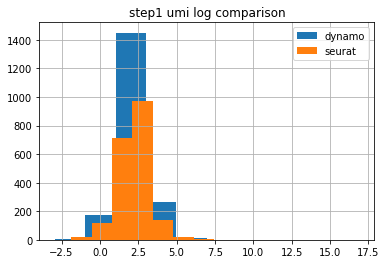

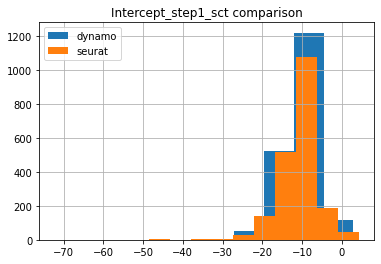

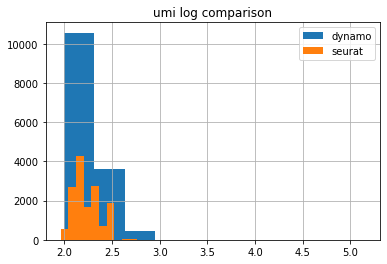

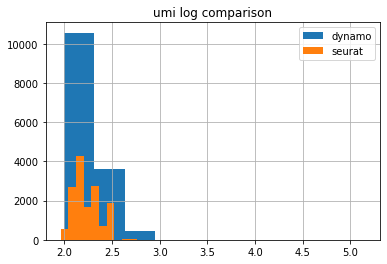

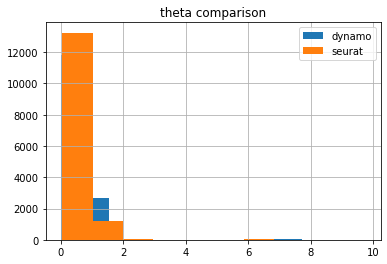

<Figure size 432x288 with 0 Axes>

In [16]:
dyn_adata_preprocessor.var["log_umi_step1_sct"].hist(label="dynamo")
seurat_features["step1_log_umi"].hist(label="seurat")
plt.title("step1 umi log comparison")
plt.legend()
plt.show()
plt.clf()

dyn_adata_preprocessor.var["Intercept_step1_sct"].hist(label="dynamo")
seurat_features["step1_(Intercept)"].hist(label="seurat")
plt.title("Intercept_step1_sct comparison")
plt.legend()
plt.show()
plt.clf()

dyn_adata_preprocessor.var["log_umi_sct"].hist(label="dynamo")
seurat_features["log_umi"].hist(label="seurat")
plt.title("umi log comparison")
plt.legend()
plt.show()
plt.clf()

dyn_adata_preprocessor.var["log_umi_sct"].hist(label="dynamo")
seurat_features["log_umi"].hist(label="seurat")
plt.title("umi log comparison")
plt.legend()
plt.show()
plt.clf()

dyn_adata_preprocessor.var["theta_sct"].hist(label="dynamo")
seurat_features["theta"].hist(label="seurat")
plt.title("theta comparison")
plt.legend()
plt.show()
plt.clf()


Text(0.5, 1.0, 'X_pca')

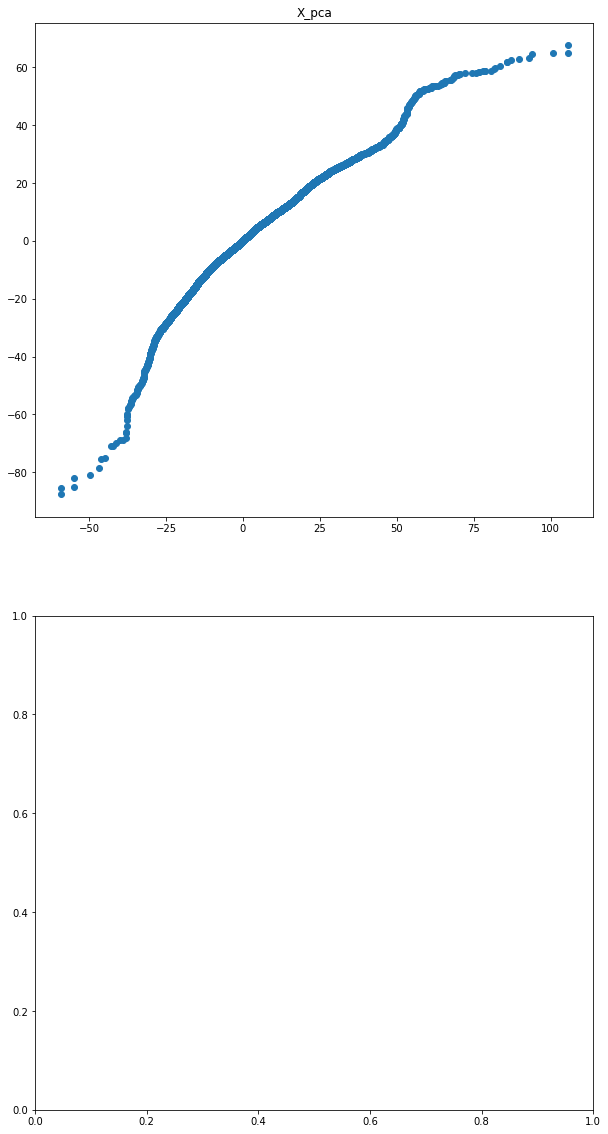

In [17]:
fig, axes = plt.subplots(2, figsize=(10, 20))
key = "X_pca"
use_for_pca = list(
    set(dyn_adata_preprocessor.var_names[dyn_adata_preprocessor.var["use_for_pca"]]))
axes[0].scatter(np.sort(dyn_adata_preprocessor.obsm[key].flatten()),
                np.sort(seurat_adata[dyn_adata_preprocessor.obs_names, :].obsm[key].flatten()))  # , title="X_pca comparison")
axes[0].set_title(key)


In [18]:

dyn.tl.reduceDimension(seurat_adata, basis="pca")
dyn.pl.umap(seurat_adata, color="Cell_type", figsize=(10, 10))


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


In [ ]:
dyn.tl.reduceDimension(dyn_adata_preprocessor, basis="pca")
dyn.pl.umap(dyn_adata_preprocessor, color="Cell_type", figsize=(10, 10))
